In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
%matplotlib inline
import numpy as np
import numpy.ma as ma
import os
import pickle
import itertools

import sys
# sys.path.append('/scratch9/mkron/software/DeepIceLearning/notebooks')
#import plot_functions_mk as pfmk
from fancy_plot import *
# from plot_conf import *
from icecube import NewNuFlux
if not os.path.exists('./out/'):
    os.makedirs('./out/')


In [85]:
def retag_classify(ClassLabel):
    class_scheme = {0:0, 1:0, 2:1, 3:1, 4:1, 5:2, 6:2, 7:0, 8:1, 9:0}
    ClassLabelRetag = ClassLabel
    for key in class_scheme.keys():
        ClassLabelRetag[ClassLabel == key] = class_scheme[key]
    return ClassLabelRetag

def retag_classify_startTrack(ClassLabel):
    class_scheme = {0:0, 1:0, 2:1, 3:3, 4:1, 5:2, 6:2, 7:0, 8:1, 9:0}
    ClassLabelRetag = ClassLabel
    for key in class_scheme.keys():
        ClassLabelRetag[ClassLabel == key] = class_scheme[key]
    return ClassLabelRetag

def summary_plot_binary_target(pred_target, MC_target, classes, quantity, binnumber):

    # masking the lists to the labels
    E_for_class1 = quantity[MC_target == 0]
    E_for_class2 = quantity[MC_target == 1]

    # calculating values for the confusion matrix
    absolute, xe,ye = np.histogram2d(pred_target, MC_target, bins=(len(classes),len(classes)))
    # that means that the prediction has to correspond to a event type 
    res_true = absolute/np.sum(absolute,axis=0)
    # normalization if the absolute values, so that the sum over PREDICTION is 1
    # that means that a event hast to be predicted as one type 
    res_pred = absolute/np.sum(absolute,axis=1).reshape(-1,1)

    # PLOT
    fig = plt.figure(figsize=(16, 16))
    ax1 = plt.subplot2grid((3, 2), (0, 0))
    ax1 = acc_vs_quantity_plot(pred_target, MC_target, 0, quantity,
                               "Accuracy vs. Energy for class {}".format(classes[0]),
                               binnumber, ax1)

    ax2 = plt.subplot2grid((3, 2), (0, 1))
    ax2 = acc_vs_quantity_plot(pred_target, MC_target, 1, quantity,
                               "Accuracy vs. Energy for class {}".format(classes[1]),
                               binnumber, ax2)

    ax3 = plt.subplot2grid((3, 2), (1, 0))
    bins = np.linspace(np.min(np.log10(E_for_class1)), np.max(np.log10(E_for_class1)), binnumber)
    valsAll = np.histogram(np.log10(E_for_class1), bins=bins)[0]
    ax3.semilogy(bins[:-1], valsAll, drawstyle = 'steps-mid')
    ax3.set_title("Statistic of {} Events vs. Energy".format(classes[0]), fontsize=16)
    ax3.set_xlabel(r'$\log_{10}$(E) [GeV]', fontsize=16)
    ax3.set_ylabel('amount of events', fontsize=16)

    ax4 = plt.subplot2grid((3, 2), (1, 1))
    bins = np.linspace(np.min(np.log10(E_for_class2)), np.max(np.log10(E_for_class2)), binnumber)
    valsAll = np.histogram(np.log10(E_for_class2), bins=bins)[0]
    ax4.semilogy(bins[:-1], valsAll, drawstyle = 'steps-mid')
    ax4.set_title("Statistic of {} Events vs. Energy".format(classes[1]), fontsize=16)
    ax4.set_xlabel(r'$\log_{10}$(E) [GeV]', fontsize=16)
    ax4.set_ylabel('amount of events', fontsize=16)

    ax5 = plt.subplot2grid((3, 2), (2, 0))
    plot_confusion_matrix(res_true, classes=classes, title='Confusion matrix normalized on MCTruth')

    ax6 = plt.subplot2grid((3, 2), (2, 1))
    plot_confusion_matrix(res_pred, classes=classes, title='Confusion matrix normalized on PREDICTION')

def acc_vs_energy_plot_perType(pred, true, energy, title, binnumber):

    was_NN_right = [] #was_NN_right: Mask with 1 if prediction was right, if not 0
    for i in xrange(0,len(pred)):
        if np.argmax(pred[i]) == true[i]:
            was_NN_right.append(1)
        else:
            was_NN_right.append(0)

    bins = np.linspace(np.min(np.log10(energy)), np.max(np.log10(energy)), binnumber)
    valsTrue = np.histogram(np.log10(energy), weights=was_NN_right, bins=bins)[0]
    valsAll = np.histogram(np.log10(energy), bins=bins)[0]
    acc = 1.*valsTrue/valsAll

    plt.plot(bins[:-1], acc, "x")
    #plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    #plt.ylabel()
    #plt.xlabel()
 
def plot_confusion_matrix(cm, classes,title="", thresh=0.2, cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=18)
    plt.yticks(tick_marks, classes, fontsize=18)

    thresh = thresh
    for i, j in itertools.product(range(len(classes)), range(len(classes))):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=14)

    plt.ylabel('Predicted label', fontsize=18)
    plt.xlabel('True label', fontsize=18)


def acc_vs_quantity_plot(pred, true_label, true, quantity, title, bins, ax, weights=1, add_mask=[]):
    
    if isinstance(bins, int):
        bins = np.linspace(np.min(quantity), np.max(quantity), bins)
    if add_mask == []:
        add_mask = np.array([True]*len(pred))
    
    mask_label = (true_label == true) & add_mask
    mask_label_pred = (true_label == true) & (pred==true_label) & add_mask
    valsTrue = np.histogram(quantity[mask_label_pred], bins=bins, weights=weights[mask_label_pred])[0]
    valsAll = np.histogram(quantity[mask_label], bins=bins, weights=weights[mask_label])[0]
    acc = 1.*valsTrue/valsAll
    acc[valsAll==0]=0
    ax.plot(bins[:-1], acc, drawstyle='steps-mid')
    
    mask_label = (pred == true) & add_mask
    mask_label_pred = (pred == true) & (pred==true_label) & add_mask
    valsTrue = np.histogram(quantity[mask_label_pred], bins=bins, weights=weights[mask_label_pred])[0]
    valsAll = np.histogram(quantity[mask_label], bins=bins, weights=weights[mask_label])[0]
    acc = 1 - 1.*valsTrue/valsAll
    acc[valsAll==0]=0
    ax.plot(bins[:-1], acc, drawstyle='steps-mid', color='blue')    
    ax.set_ylim(0.0,1.1)
    ax.set_title(title)
    return ax

def acc_loss_plot(acc_train, loss_train, acc_val, loss_val, title):
    x = np.linspace(1, len(acc_train), num=len(acc_train), endpoint=True)
    plt.plot(x, acc_train, color="#0099cc", label="acc of the training set")
    plt.plot(x, loss_train, color='#35bcf8', label="loss of the training set")
    plt.plot(x, acc_val, color='#6c1ba1', label="acc of the validation set")
    plt.plot(x, loss_val, color='#af27cd', label="loss of the validation set")
    plt.title(title, fontsize=18)
    #plt.set_ylim(0., 1.8)
    plt.legend(bbox_to_anchor=(0.59, 0.97), loc=2, borderaxespad=0.)
    plt.ylabel('loss & percentage', fontsize=16)
    plt.xlabel("epochs", fontsize=16)

def acc_of_classifier_vs_x(pred, true, x, title, xlabel, ylabel, binnumber):

    was_classifier_right = [] #was_NN_right: Mask with 1 if prediction was right, if not 0
    for i in xrange(0,len(pred)):
        if np.argmax(pred[i]) == true[i]:
            was_classifier_right.append(1)
        else:
            was_classifier_right.append(0)
            
    
    bins = np.linspace(np.min(x), np.max(x), binnumber)
    valsTrue = np.histogram(x, weights=was_classifier_right, bins=bins)[0]
    valsAll = np.histogram(x, bins=bins)[0]
    acc = 1.*valsTrue/valsAll

    plt.plot(bins[:-1], acc, "x")
    #plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    return
  
def barchart_classes(classes, values, title, ylabel, xlabel):
    fig, ax = newfig(0.9)
    y_pos = np.arange(len(classes))
    couleur = ['#0000FF', '#0099FF', '#14b3e6', '#1480e6']
    total = sum(values)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    
    for i in xrange(len(classes)):
        if 1.0*values[i]/total < 0.2:
            plt.text(y_pos[i], values[i]/2, '{:.0f}'.format(1.*values[i]), horizontalalignment="center",\
                    verticalalignment='bottom', rotation='0', color="black")
        else:
            plt.text(y_pos[i], values[i]/2, '{:.0f}'.format(1.*values[i]), horizontalalignment="center",\
                    verticalalignment='bottom', rotation='0', color="white")
            
    plt.bar(y_pos, values, align='center', alpha=1.0, color=couleur)
    ax.set_xticks(range(len(classes)))
    ax.set_xticklabels(classes, rotation='45')
    plt.show()
    

def confusion_process(input_X, true_X, classes, weights=[]):
    xedges = [-0.5, 0.5, 1.5, 2.5, 3.5]
    yedges = [-0.5, 0.5, 1.5, 2.5, 3.5]
    if weights == []:
        weights = np.ones(len(input_X))
    absolute, xe,ye = np.histogram2d(input_X, true_X, bins=(xedges, yedges), weights = weights)
    res_true = absolute/np.sum(absolute,axis=0)
    # normalization if the absolute values, so that the sum over PREDICTION is 1
    # that means that a event hast to be predicted as one type 
    res_pred = absolute/np.sum(absolute,axis=1).reshape(-1,1)
    
    fig = plt.figure(figsize=(25, 8))
    ax13 = plt.subplot2grid((1, 3), (0, 0))
    plot_confusion_matrix(res_true, classes=classes, title='Confusion matrix normalized on TRUTH', thresh=0.75)

    ax14 = plt.subplot2grid((1, 3), (0, 1))
    plot_confusion_matrix(res_pred, classes=classes, title='Confusion matrix normalized on PREDICTION', thresh=0.75)

    ax14 = plt.subplot2grid((1, 3), (0, 2))
    plot_confusion_matrix(absolute, classes=classes, title='Confusion matrix ABSOLUTE', thresh=20000.)
    return fig

    
def performence_target(pred, true):
    NN_correct = 0
    for i in xrange(len(true)):
        if np.argmax(pred[i]) == true[i]:
            NN_correct += 1
    return 1.*NN_correct/len(true)*100

#np.max(np.log10(hitDOMs_for_class1))
#bins = np.linspace(np.min(np.log10(hitDOMs_for_class1)), np.max(np.log10(hitDOMs_for_class1)), 20)

def acc_vs_hitDOMs_plot(pred, true, hitDOMs, title, binnumber):

    was_NN_right = [] #was_NN_right: Mask with 1 if prediction was right, if not 0
    for i in xrange(0,len(pred)):
        if np.argmax(pred[i]) == true:
            was_NN_right.append(1)
        else:
            was_NN_right.append(0)


    bins = np.linspace(np.min(hitDOMs), np.max(hitDOMs), binnumber)
    valsTrue = np.histogram(hitDOMs, weights=was_NN_right, bins=bins)[0]
    valsAll = np.histogram(hitDOMs, bins=bins)[0]
    acc = 1.*valsTrue/valsAll


    plt.plot(bins[:-1], acc, "x")
    #plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.ylabel('accuracy', fontsize=16)
    plt.xlabel('number of hit DOMs', fontsize=16)

###### Allocation of variables

In [205]:
# DATA_DIR = "/scratch9/tglauch/NN_out/run37/"
DATA_DIR = "../output/DB/"

predictions_mctrue = pickle.load(file(os.path.join(DATA_DIR, 'best_val_loss_pred.pickle')))
sample_len = len(predictions_mctrue['prediction'][0])

pred_label_1 = predictions_mctrue["prediction"][0] #list with probability for each class
true_label_1 = retag_classify_startTrack(predictions_mctrue["mc_truth"]
                                        ["ClassificationLabel_truth"][:sample_len])
all_pred = np.argmax(pred_label_1, axis=1)
classes_1 = ("Cascade", "Track", "Double Bang", "StartingTrack")

zenith_pred = np.arccos(-predictions_mctrue["reco_vals"]['dir_z'][:sample_len])
zenith_true = np.arccos(-predictions_mctrue['mc_truth']['dir_z_truth'][:sample_len])

# Number of hit DOMs
IC_hitDOMs = predictions_mctrue["IC_HitDOMs"][:sample_len]
DC_hitDOMs = predictions_mctrue["DC_HitDOMs"][:sample_len]
hitDOMs = IC_hitDOMs + DC_hitDOMs

energy=predictions_mctrue["reco_vals"]['energyFirstParticle']
ptype = predictions_mctrue["reco_vals"]['firstParticle'][:sample_len]
class_label = predictions_mctrue["reco_vals"]['ClassificationLabel'][:sample_len]
azimuth_pred = np.arctan2(predictions_mctrue["reco_vals"]['dir_y'][:sample_len],
                         predictions_mctrue["reco_vals"]['dir_x'][:sample_len])
inelasticity=predictions_mctrue["reco_vals"]['inelasticity'][:sample_len]
tau_decay_length=predictions_mctrue["reco_vals"]['TauDecayLength'][:sample_len]

In [206]:
wdict = {0:3, 1:1, 2:3, 3:6, 4:1, 5:30, 6:1, 7:1, 8:1, 9:1}
clen = dict()
for ev_type in [12, 14, 16]:
    clen[ev_type] = np.sum([len(np.where(np.abs(ptype[class_label==key])==ev_type)[0])/wdict[key] for key in wdict.keys()])
print clen

{16: 21536, 12: 43300, 14: 45328}


In [92]:
atm_flux = NewNuFlux.makeFlux('honda2006')
atm_flux.knee_reweighting_model = "gaisserH4a_elbert"
prompt_flux = NewNuFlux.makeFlux('sarcevic_max')
prompt_flux.knee_reweighting_model = "gaisserH4a_elbert"
# return ow * flux.getFlux(ptype, energy, cos_theta)

powerlaw = lambda energy: 1.08e-18*(energy*1e-5)**(-2.0)

def calc_weights(events):
    wdict = {0:3, 1:1, 2:3, 3:6, 4:1, 5:30, 6:1, 7:1, 8:1, 9:1}
    clen = dict()
    for ev_type in [12, 14, 16]:
        clen[ev_type] = np.sum([len(np.where(np.abs(ptype[class_label==key])==ev_type)[0])/wdict[key] 
                                for key in wdict.keys()])
    print clen
    atm_weight = []
    prompt_weight = []
    astro_weight = []
    for ev in events:
        correct_ow = ev['ow']/clen[np.abs(ev['firstParticle'])]/wdict[ev['ClassificationLabel']]/100
        atm_weight.append(correct_ow*atm_flux.getFlux(ev['firstParticle'],
                          ev['energyFirstParticle'], -ev['dir_z'])*2)
        prompt_weight.append(correct_ow*prompt_flux.getFlux(ev['firstParticle'],
                             ev['energyFirstParticle'], -ev['dir_z'])*2)
        astro_weight.append(correct_ow*powerlaw(ev['energyFirstParticle']))
    return np.array(atm_weight), np.array(prompt_weight), np.array(astro_weight)
        
    

In [93]:
w1, w2, w3 = calc_weights(predictions_mctrue["reco_vals"][:sample_len])
tot_weight = w1 + w2 + w3

{16: 21536, 12: 43300, 14: 45328}


In [94]:
print 'Rate of atmo flux: {}'.format(np.sum(w1)*np.pi*1e7*2)
print 'Rate of prompt flux : {}'.format(np.sum(w2)*np.pi*1e7*2)
print 'Rate of astro flux : {}'.format(np.sum(w3)*np.pi*1e7*2)

Rate of atmo flux: 29415.7978306
Rate of prompt flux : 632.5757797
Rate of astro flux : 647.107258612


## Target 1 : Event Type

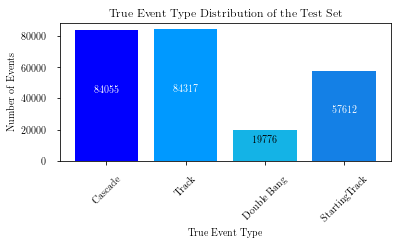

In [95]:
# composition of the Test Set according to the Event Tybe Lables
# Double check
barchart_classes(classes_1,
         [true_label_1.tolist().count(0), true_label_1.tolist().count(1), true_label_1.tolist().count(2),
          true_label_1.tolist().count(3)],
         'True Event Type Distribution of the Test Set', 'Number of Events', "True Event Type")

#### Acc 

In [96]:
#How many of all the predictions were right, independent of Event Type
print "General Acc for Event Typologies: {}".format(performence_target(pred_label_1 , true_label_1))

General Acc for Event Typologies: 73.6905924479


In [144]:
np.sum(tot_weight[add_mask])

9736.332384625648

### Confusion Plot

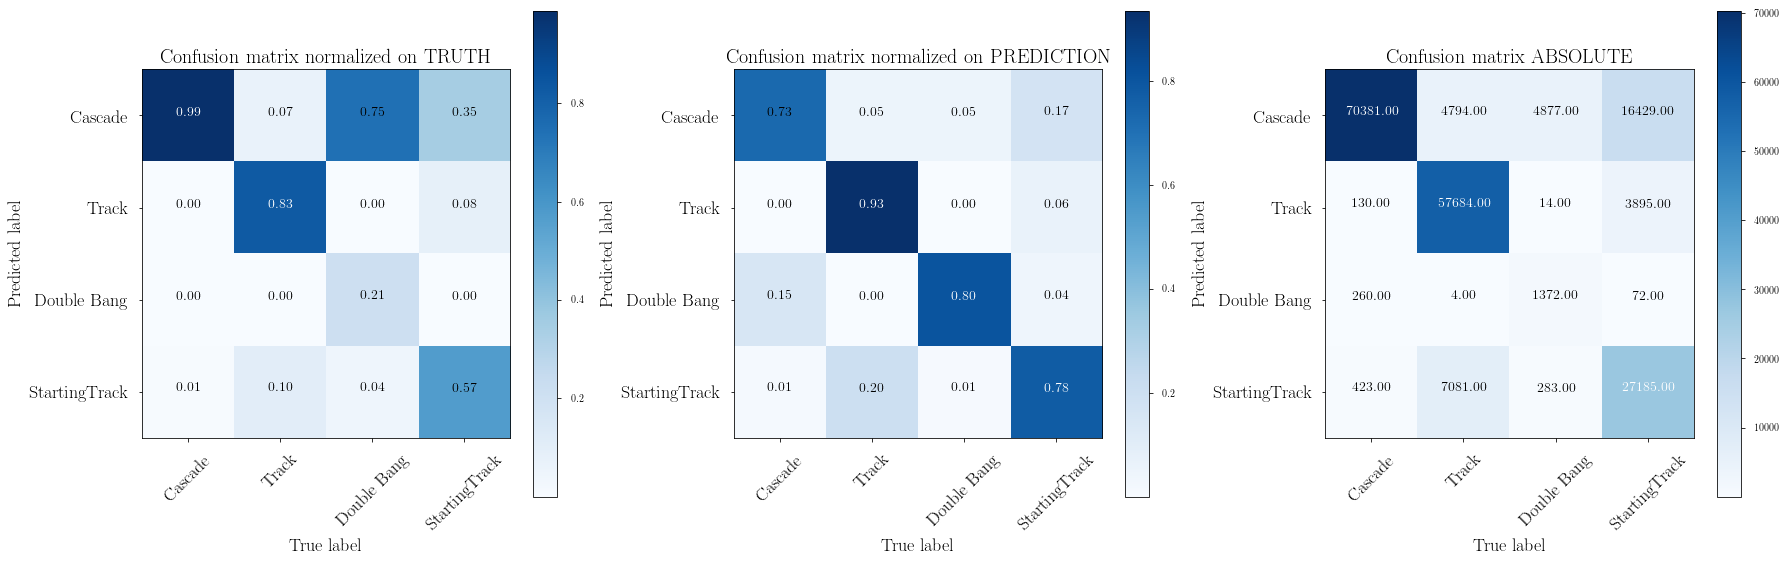

In [195]:
add_mask = np.max(pred_label_1, axis=1)>0.60
fig = confusion_process(all_pred[add_mask],
                        true_label_1[add_mask],
                        classes_1,)
    #                    weights=tot_weight[add_mask])
plt.show()
fig.savefig('./out/confusion_matrix.png',dpi=300)

### Acc and corresponding statistic vs. Hit DOMS

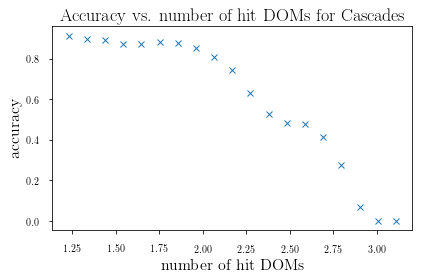

In [46]:
acc_vs_hitDOMs_plot(pred_label_1[true_label_1 ==0], 0, np.log10(hitDOMs[true_label_1 == 0]), "Accuracy vs. number of hit DOMs for Cascades", 20)

{16: 21536, 12: 43300, 14: 45328}


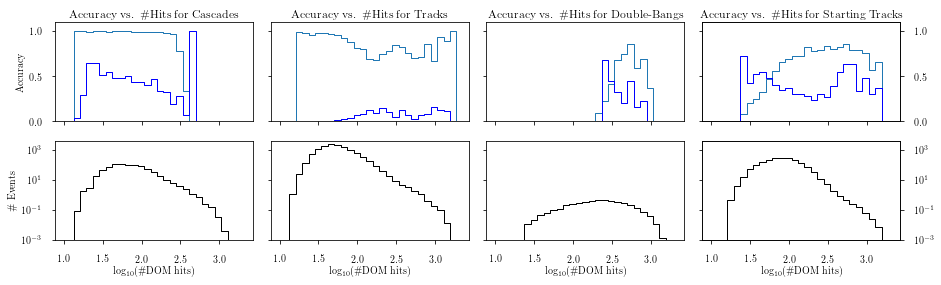

In [139]:
energy_dic = {'arr' : np.log10(energy), 'xbins' : np.linspace(1, 8, 30), 'title':'Energy',
              'xlabel': r'$\log_{10}$(E) [GeV]' , 'name' : 'energy'}
hits_dic = {'arr' : np.log10(IC_hitDOMs), 'xbins' : np.linspace(1, 3.4, 30), 'title': '\#Hits',
            'xlabel': r'$\log_{10}$(\#DOM hits)', 'name': 'hits'}


flux_weight = True
which = hits_dic # <--------Set this one
add_mask =  np.max(pred_label_1, axis=1)>0.7
add_str = 'strack_y_0.8_cut'

if flux_weight:
    atm_w, prompt_w, astro_w = calc_weights(predictions_mctrue["reco_vals"][:sample_len])
    tot_weight = (atm_w + prompt_w + astro_w)*np.pi*1e7
    add_str += 'flux_weight_'
else:
    tot_weight=np.ones(len(all_pred))
    add_str += 'no_weight_'
    

add_str += which['name']+'_'

if add_mask == []:
    add_mask = np.array([True]*len(tot_weight))

fig1 = plt.figure(figsize=(2*1.618*4.07, 4.07))

ax1 = plt.subplot2grid((2, 4), (0, 0))
ax1 = acc_vs_quantity_plot(all_pred, true_label_1, 0,
                         which['arr'],
                         r"Accuracy vs. {} for Cascades".format(which['title']),
                         which['xbins'], ax1, weights=tot_weight, add_mask = add_mask)
ax1.set_xticklabels([])
ax1.set_ylabel('Accuracy')

ax2 = plt.subplot2grid((2, 4), (0, 1))
ax2 = acc_vs_quantity_plot(all_pred, true_label_1, 1,
                         which['arr'],
                         r"Accuracy vs. {} for Tracks".format(which['title']),
                         which['xbins'], ax2, weights=tot_weight, add_mask = add_mask)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

ax3 = plt.subplot2grid((2, 4), (0, 2))
ax3 = acc_vs_quantity_plot(all_pred, true_label_1, 2,
                         which['arr'], r"Accuracy vs. {} for Double-Bangs".format(which['title']),
                         which['xbins'], ax3, weights=tot_weight, add_mask = add_mask)
ax3.set_xticklabels([])
ax3.set_yticklabels([])

ax31 = plt.subplot2grid((2, 4), (0, 3))
ax31 = acc_vs_quantity_plot(all_pred, true_label_1, 3,
                          which['arr'], r"Accuracy vs. {} for Starting Tracks".format(which['title']),
                          which['xbins'], ax31,weights=tot_weight, add_mask = add_mask)
ax31.set_xticklabels([])
ax31.set_yticklabels([])
ax31_2 = ax31.twinx()
ax31_2.set_ylim(ax31.get_ylim())

ax4 = plt.subplot2grid((2, 4), (1, 0))
max_vals = []
mask = (true_label_1 == 0)
valsAll = np.histogram(which['arr'][mask], bins=which['xbins'],
                       weights=tot_weight[mask])[0]
max_vals.append(np.max(valsAll))
ax4.semilogy(which['xbins'][:-1], valsAll, drawstyle = 'steps-mid', color='k')
ax4.set_xlabel(which['xlabel'])
ax4.set_ylabel(r'\# Events')

ax5 = plt.subplot2grid((2, 4), (1, 1))
mask = (true_label_1 == 1)
valsAll = np.histogram(which['arr'][mask], bins=which['xbins'],
                      weights=tot_weight[mask])[0]
ax5.semilogy(which['xbins'][:-1], valsAll, drawstyle = 'steps-mid', color='k')
ax5.set_xlabel(which['xlabel'])
max_vals.append(np.max(valsAll))
ax5.set_yticklabels([])

ax6 = plt.subplot2grid((2, 4), (1, 2))
mask = (true_label_1 == 2)
valsAll = np.histogram(which['arr'][mask], bins=which['xbins'],
                      weights=tot_weight[mask])[0]
ax6.semilogy(which['xbins'][:-1], valsAll, drawstyle = 'steps-mid', color='k')
ax6.set_xlabel(which['xlabel'])
ax6.set_yticklabels([])
max_vals.append(np.max(valsAll))

ax61 = plt.subplot2grid((2, 4), (1, 3))
mask = (true_label_1 == 3)
valsAll = np.histogram(which['arr'][mask], bins=which['xbins'],
                      weights=tot_weight[mask])[0]
ax61.semilogy(which['xbins'][:-1], valsAll, drawstyle = 'steps-mid', color='k')
ax61.set_xlabel(which['xlabel'])
ax61.set_yticklabels([])
max_vals.append(np.max(valsAll))

ax4.set_ylim(0.001, 1.5*np.max(max_vals))
ax5.set_ylim(0.001, 1.5*np.max(max_vals))
ax6.set_ylim(0.001, 1.5*np.max(max_vals))
ax61.set_ylim(0.001, 1.5*np.max(max_vals))
ax61_2 = ax61.twinx()
ax61_2.set_ylim(ax61.get_ylim())
ax61_2.set_yscale('log')
plt.tight_layout()
fig1.subplots_adjust(wspace=0.0, hspace=0.0)
fig1.savefig('./out/accuracy_{}.pdf'.format(add_str))
plt.show()

## Target 2: Starting

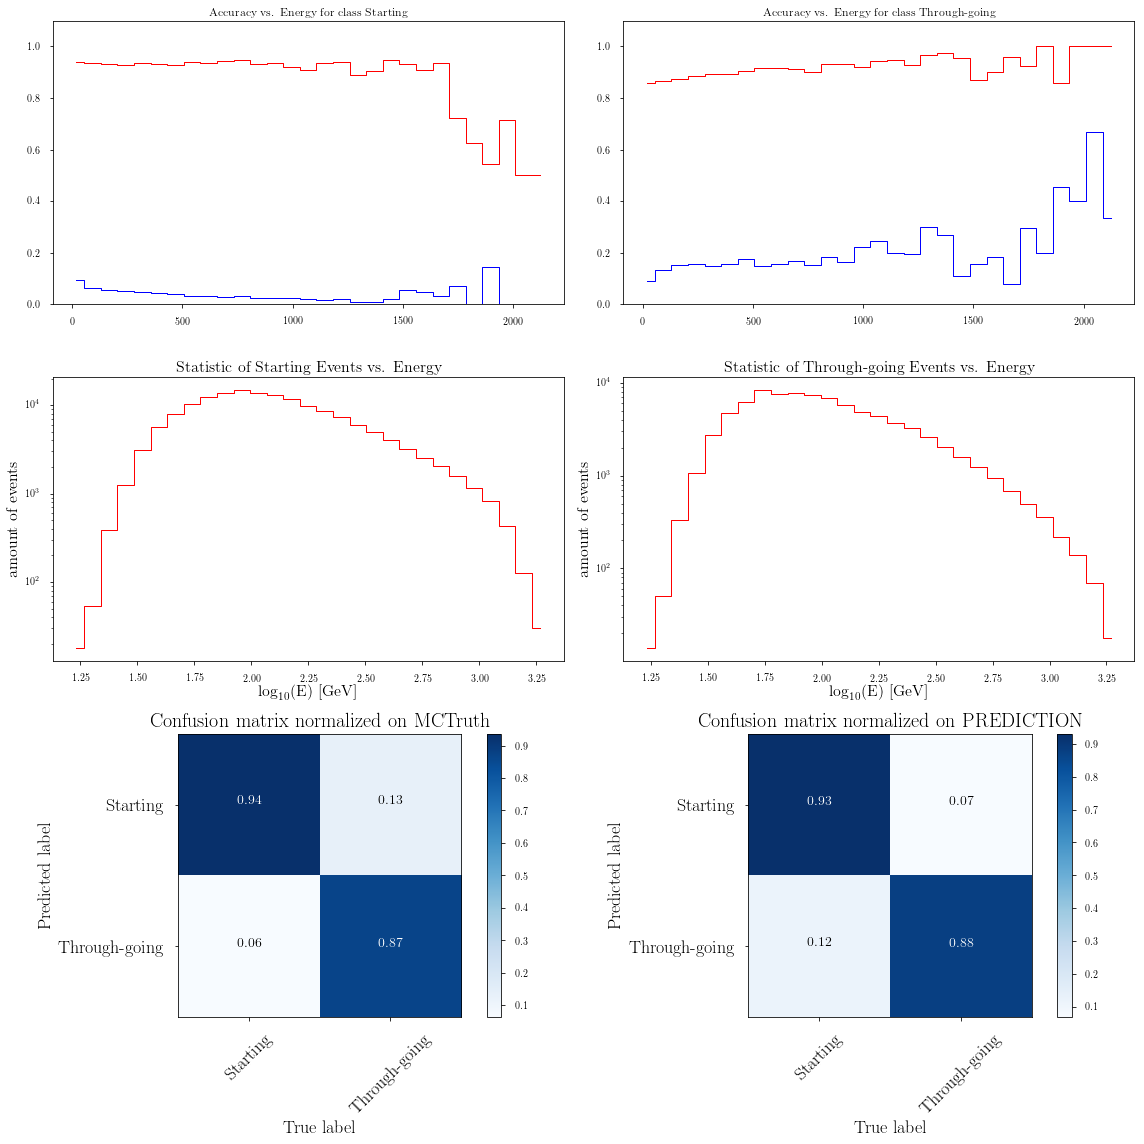

In [10]:
summary_plot_binary_target(np.argmax(pred_label_2, axis=1), true_label_2, ("Starting", "Through-going"), hitDOMs, 30)

## Target 3: Zenith Regression

Text(0,0.5,'counts')

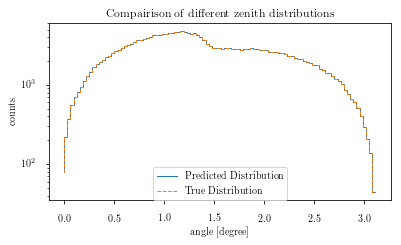

In [210]:
fig, ax1 = newfig(0.9)
vals_pred, bins = np.histogram(zenith_pred, bins=100)
ax1.semilogy(bins[:-1], vals_pred, drawstyle='steps-pre', label="Predicted Distribution")
vals_true, bins = np.histogram(zenith_true, bins=100)
ax1.semilogy(bins[:-1], vals_true, drawstyle='steps-pre', label="True Distribution", linestyle = '--')
ax1.legend(loc ='best', ncol=1, borderaxespad=0.)
ax1.set_title(r"Compairison of different zenith distributions")
ax1.set_xlabel(r'angle [degree]')
ax1.set_ylabel(r'counts')

KeyboardInterrupt: 

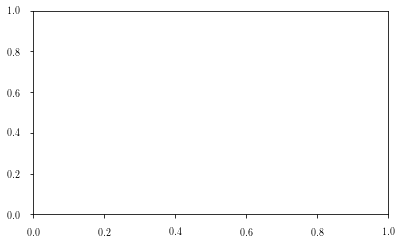

In [211]:
fig, ax1 = newfig(0.9)
masks = [true_label_1 ==0, true_label_1 ==1, true_label_1 ==2 ]
for mask in masks:
    diff = np.array(true_label_3[mask]) - np.array(pred_label_3[mask])
    vals, bins = np.histogram(diff, bins=100)
    ax1.plot(bins[:-1], vals, drawstyle='steps-pre', label="Diff Distribution")
ax1.legend(ncol=1, borderaxespad=0., loc ='best') #bbox_to_anchor=(0.975 , 0.3),
ax1.set_title(r"Differenz of prediction and truth")
ax1.set_xlabel(r'angle [degree]')
ax1.set_ylabel(r'counts')

## Extremeness of Predictions
##### Probabilitys of Predictions

In [127]:
def prob(pred, log, title):
    prob_cascade = []
    prob_track = []
    prob_db = []
    prob_sT = []
    for i in xrange(len(pred)):
        prob_cascade.append(pred[i][0])
        prob_track.append(pred[i][1])
        prob_db.append(pred[i][2])
        prob_sT.append(pred[i][3])

    bins = np.linspace(0, 1, 100)
    valsCascade = np.histogram(prob_cascade, bins=bins)[0]
    valsTrack = np.histogram(prob_track, bins=bins)[0]
    valsDB = np.histogram(prob_db, bins=bins)[0]
    valssT = np.histogram(prob_sT, bins=bins)[0]
    
    if log:
        plt.semilogy(bins[:-1], valsCascade, drawstyle = 'steps-mid', label="Cascade")
        plt.semilogy(bins[:-1], valsTrack, drawstyle = 'steps-mid', label="Track")
        plt.semilogy(bins[:-1], valsDB, drawstyle = 'steps-mid', label="Double Bang")
        plt.semilogy(bins[:-1], valssT, drawstyle = 'steps-mid', label="Starting Track")
    else:
        plt.plot(bins[:-1], valsCascade, drawstyle = 'steps-mid', label="Cascade")
        plt.plot(bins[:-1], valsTrack, drawstyle = 'steps-mid', label="Track")
        plt.plot(bins[:-1], valsDB, drawstyle = 'steps-mid', label="Double Bang")
        plt.plot(bins[:-1], valssT, drawstyle = 'steps-mid', label="Starting Track")
    plt.legend(loc='best')

    plt.title(title)
    plt.ylabel("Counts")
    plt.xlabel("Probability")

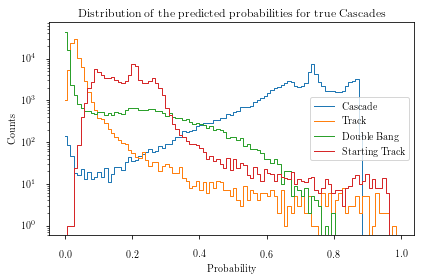

In [128]:
prob(pred_label_1[true_label_1 == 0],
     log=True,
     title="Distribution of the predicted probabilities for true Cascades")

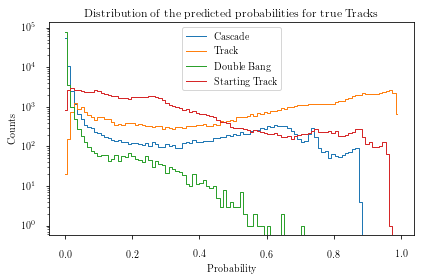

In [130]:
prob(pred_label_1[true_label_1 == 1], log=True, title="Distribution of the predicted probabilities for true Tracks")

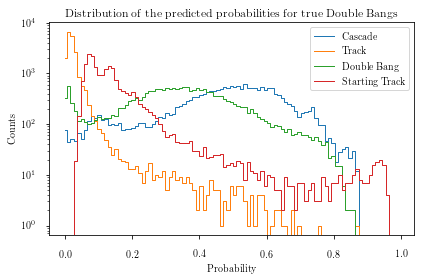

In [131]:
prob(pred_label_1[true_label_1 == 2], log=True, title="Distribution of the predicted probabilities for true Double Bangs")

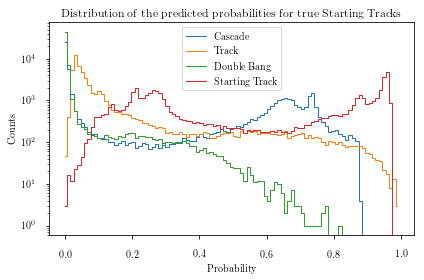

In [132]:
prob(pred_label_1[true_label_1 == 3], log=True, title="Distribution of the predicted probabilities for true Starting Tracks")

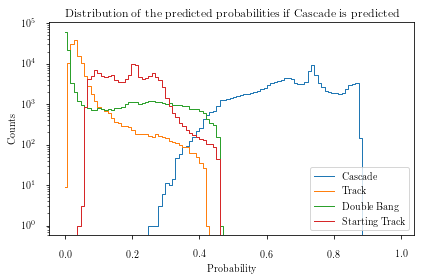

In [133]:
prob(pred_label_1[all_pred == 0], log=True, title="Distribution of the predicted probabilities if Cascade is predicted")

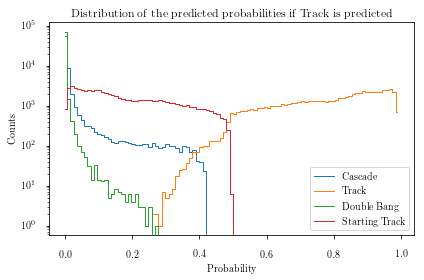

In [134]:
prob(pred_label_1[all_pred == 1], log=True, title="Distribution of the predicted probabilities if Track is predicted")

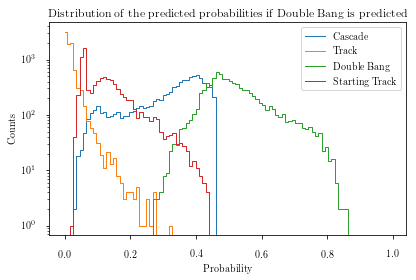

In [135]:
prob(pred_label_1[all_pred == 2], log=True, title="Distribution of the predicted probabilities if Double Bang is predicted")

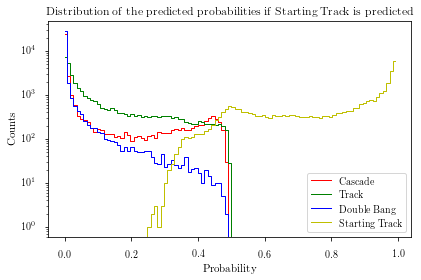

In [21]:
prob(pred_label_1[all_pred == 3], log=True, title="Distribution of the predicted probabilities if Starting Track is predicted")

In [25]:
def prob_acc(type_ind, weights=[]):
    preds = pred_label_1[all_pred == type_ind]
    truth = true_label_1[all_pred == type_ind]
    if weights == []:
        weights = np.ones(len(preds))
    else:
        weights = weights[all_pred == type_ind]
    prob = []
    for pred in preds:
        prob.append(pred[type_ind])
    prob = np.array(prob)

    x = np.linspace(0,1,100)
    val = []
    for xvalue in x:
        divider = np.sum(weights[prob > xvalue])
        if divider == 0:
            acc_i = np.max(val)
        else:
            acc_i = np.sum(weights[(prob > xvalue) & (truth==type_ind)])/divider
        val.append(acc_i)
    return val

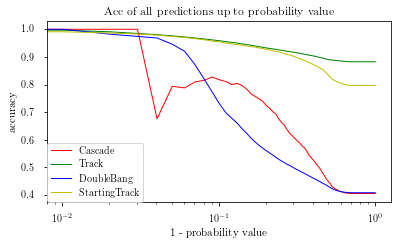

In [35]:
val_Cascade = prob_acc(0, weights=tot_weight)
val_Track = prob_acc(1)
val_DB = prob_acc(2)
val_StartTrack = prob_acc(3)
x = 1-np.linspace(0,1,100)

fig, ax1 = newfig(0.9)

ax1.plot(x, val_Cascade, label="Cascade")
ax1.plot(x, val_Track, label="Track")
ax1.plot(x, val_DB, label="DoubleBang")
ax1.plot(x, val_StartTrack, label="StartingTrack")
ax1.legend(loc ='best', ncol=1, borderaxespad=0.)
ax1.set_title(r"Acc of all predictions up to probability value")
ax1.set_xlabel(r'1 - probability value')
ax1.set_xscale('log')
ax1.set_ylabel(r'accuracy')
fig.savefig('./out/accuracy_prob.pdf')

### Cross-Dependencies of Classes

In [24]:
# if StartingTag is truely NON-STARTING, the Event classes are distributed as follow
print true_label_1[true_label_2 == 1].tolist().count(0)
print true_label_1[true_label_2 == 1].tolist().count(1)
print true_label_1[true_label_2 == 1].tolist().count(2)
print true_label_1[true_label_2 == 1].tolist().count(3)

1416
83486
0
140


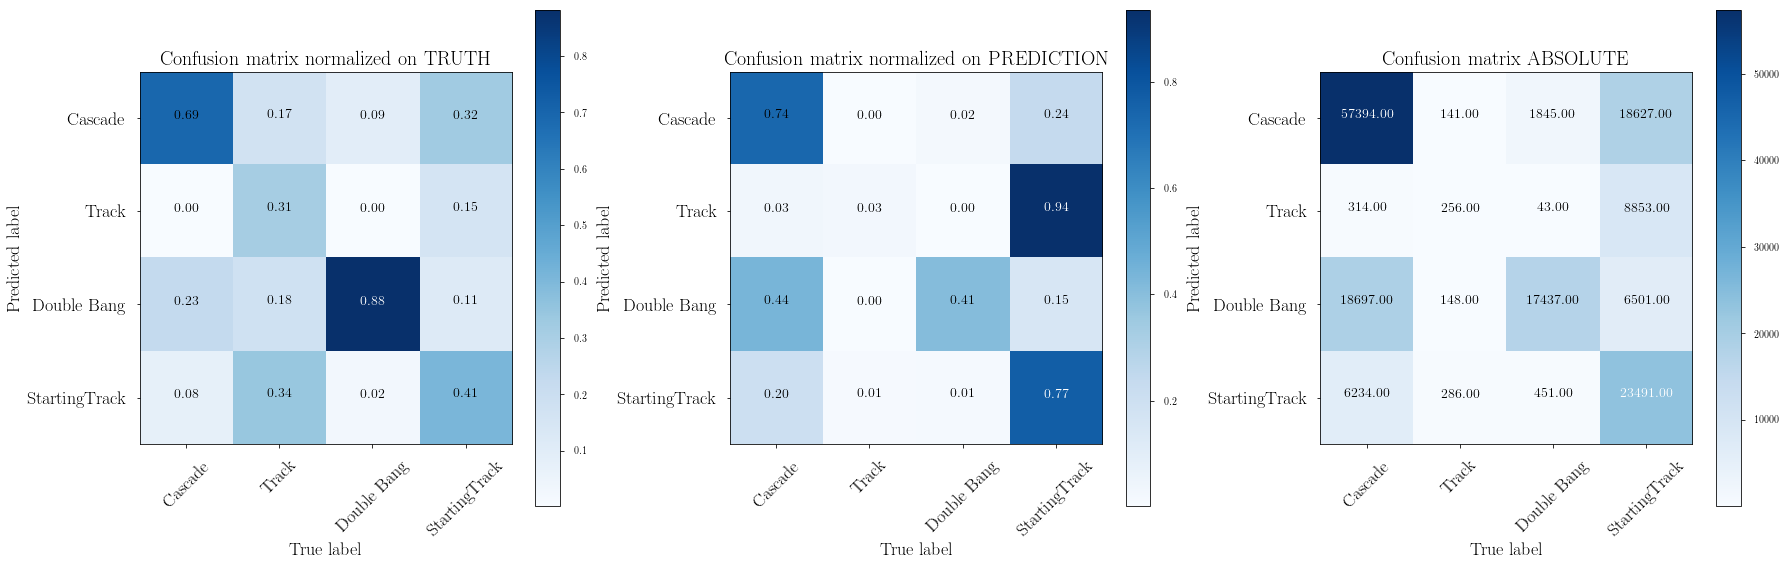

In [158]:
# Confusion martixes for only truly starting events
classes = ("Cascade", "Track", "Double Bang", "StartingTrack")

confusion_process(all_pred[true_label_2 == 0], true_label_1[true_label_2 == 0], classes)


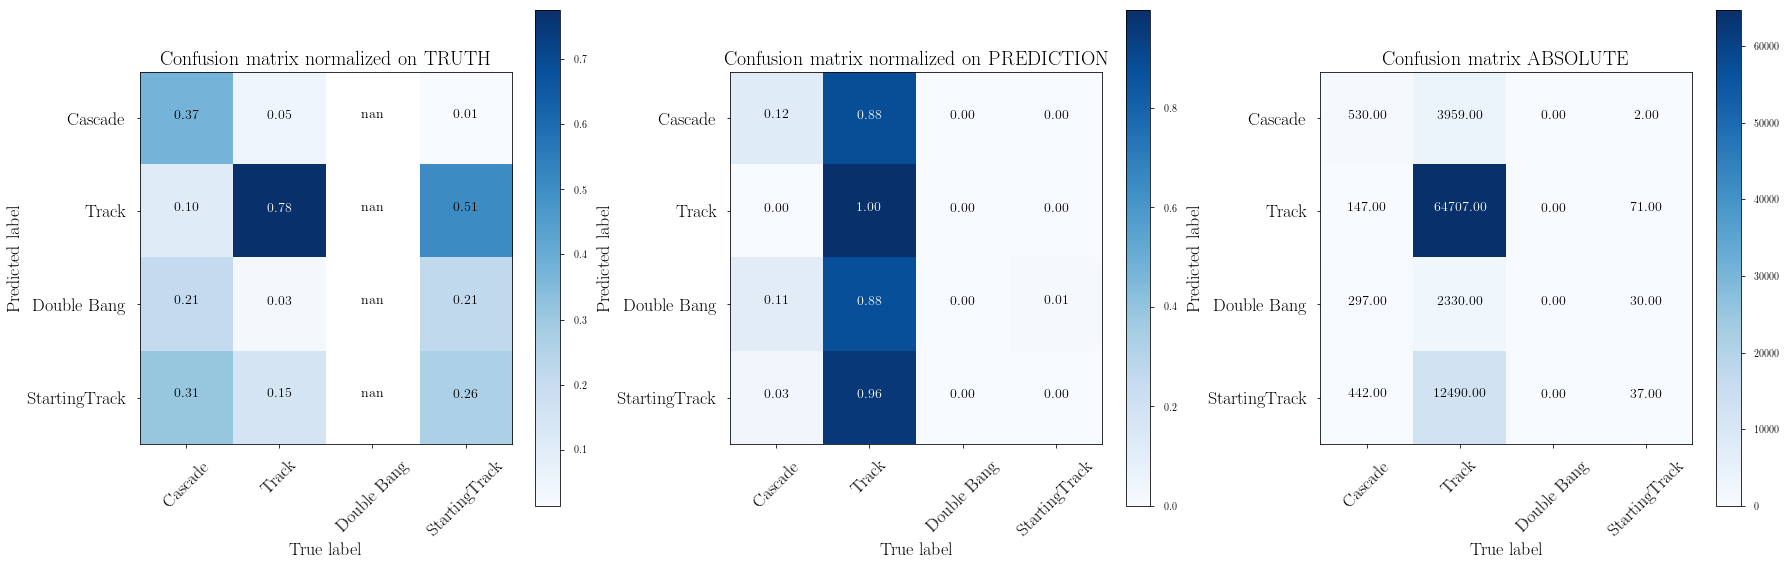

In [159]:
# Confusion martixes for only truly trough-going events
confusion_process(all_pred[true_label_2 == 1], true_label_1[true_label_2 == 1], classes)


### Inelasticity Plot

In [17]:
type_dict = {0:'Cascade', 1:'Track', 2: 'DB', 3:'Starting Track'}
# Percentage of the Events classified as one Type for all Classes given Events of one true Type, binned in an x-quantity

def perc_class_against_x(which_type, x_quantity, title, x_axis, x_min, x_max, binnumber, norm_on='true'):
        
    # percentage of true Events of given Event Type, in a given range
    if norm_on == 'true':
        ev_type = all_pred[true_label_1 == which_type] # predicted probabilities only for true EventType Events
        x_quantity = x_quantity[true_label_1 == which_type] # x only for true EventType Events
    elif norm_on == 'pred':
        ev_type = all_pred[(true_label_1 == which_type) & (all_pred!=which_type)]
        x_quantity = x_quantity[(true_label_1 == which_type) & (all_pred!=which_type)]

    fig, ax1 = newfig(0.9)
    bins = np.linspace(x_min, x_max, binnumber)
    valsAll = np.histogram(x_quantity, bins=bins)[0]

    for ev_type_key in type_dict.keys():
        ax1.plot(bins[:-1],
                1.0*np.histogram(x_quantity[ev_type == ev_type_key], bins=bins)[0]/valsAll,
                drawstyle = 'steps-mid', label=type_dict[ev_type_key])

    ax1.legend(bbox_to_anchor=(1.05 , 1.), ncol=1,
               borderaxespad=0.)
    ax1.set_title(title)
    ax1.set_xlabel(x_axis)
    ax1.set_ylabel(r'Percentage of Events')
    return fig

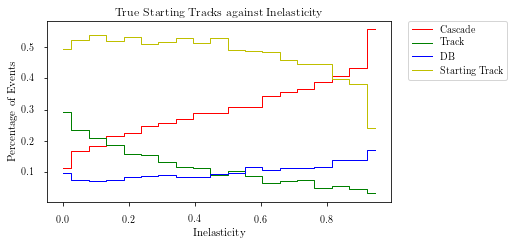

In [18]:
fig = perc_class_against_x(3, inelasticity, 
                           "True Starting Tracks against Inelasticity",
                           'Inelasticity',0, 1, 20)
fig.savefig('./out/inelasticity.pdf')

### DB acc vs. Tau decay length

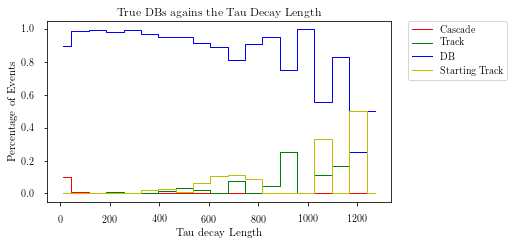

In [16]:
fig = perc_class_against_x(2,tau_decay_length, 
                           "True DBs agains the Tau Decay Length",
                           'Tau decay Length',
                            np.min(tau_decay_length[true_label_1 == 2]),
                            np.max(tau_decay_length[true_label_1 == 2]), 20)

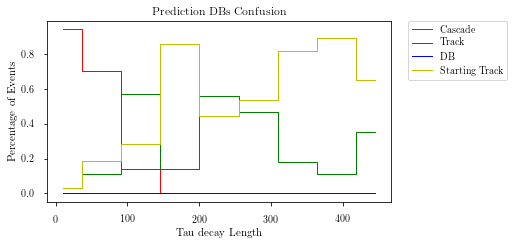

In [27]:
## What is predicted if the event is true tau but not classified as one

fig = perc_class_against_x(2, tau_decay_length, 
                           "Prediction DBs Confusion",
                           'Tau decay Length',
                            np.min(tau_decay_length[true_label_1 == 2]),
                            500, 10, norm_on='pred')

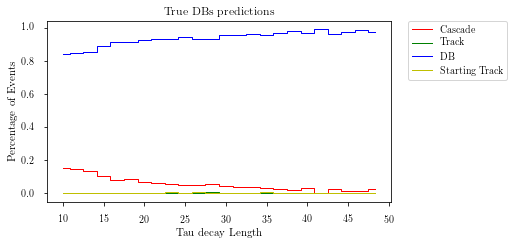

In [19]:
fig = perc_class_against_x(2, tau_decay_length, 
                           "True DBs predictions",
                           'Tau decay Length',
                            np.min(tau_decay_length[true_label_1 == 2]),
                            50, 25)

# Loos PLot

IndexError: index 14 is out of bounds for axis 0 with size 9

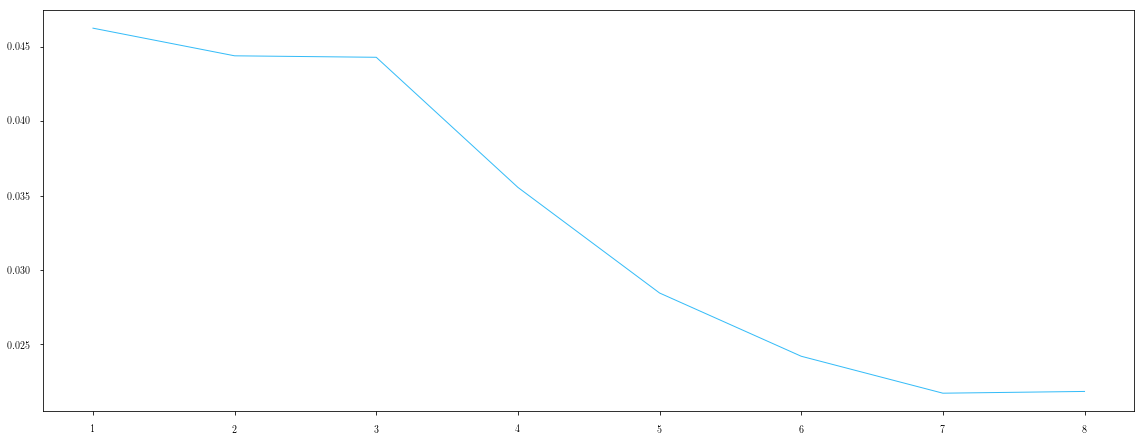

In [156]:
fig = plt.figure(figsize=(16,18))

ax0 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
x = np.linspace(1, len(epochs_acc_loss[0]), num=len(epochs_acc_loss[0]), endpoint=True)
ax0.plot(x, epochs_acc_loss[7], color="#35bcf8", label="total loss of the training set")
ax0.plot(x, epochs_acc_loss[14], color='#af27cd', label="total loss of the validation set")
ax0.legend(bbox_to_anchor=(0.79, 0.97), loc=2, borderaxespad=0.)
ax0.set_ylabel('loss & percentage')
ax0.set_xlabel("epochs")
ax0.set_title("Total Loss")

ax1 = plt.subplot2grid((3, 2), (1, 0), colspan=1)
ax1 = acc_loss_plot(acc_train_1, loss_train_1, acc_val_1, loss_val_1, "Target1: Event Type")

ax2 = plt.subplot2grid((3, 2), (1, 1), colspan=1)
ax2 = acc_loss_plot(acc_train_2, loss_train_2, acc_val_2, loss_val_2, "Target2: Starting")

ax3 = plt.subplot2grid((3, 2), (2, 0), colspan=1)
ax3 = acc_loss_plot(acc_train_3, loss_train_3, acc_val_3, loss_val_3, "Target3: UpDown")

In [57]:
# Identify the overall best run  
sum_acc_val = acc_val_1 + acc_val_2 + acc_val_3

print "ACC for the single Targets of the overall best epoch"
print "Acc on Validation Set of Target 1 Event Type : {}%".format(round(np.max(acc_val_1[np.argmax(sum_acc_val)])*100 ,2))
print "Acc on Validation Set of Target 2 Starting   : {}%".format(round(np.max(acc_val_2[np.argmax(sum_acc_val)])*100 ,2))
print "Acc on Validation Set of Target 3 UpDown: {}%".format(round(np.max(acc_val_3[np.argmax(sum_acc_val)])*100 ,2))

print np.argmax(sum_acc_val)

NameError: name 'acc_val_1' is not defined

In [58]:
print "Max ACC of the single Targets, not neccesaryly in the same epoch"
print "Acc on Validation Set of Target 1 Event Type : {}%".format(round(np.max(acc_val_1)*100 ,2))
print "Acc on Validation Set of Target 2 Starting   : {}%".format(round(np.max(acc_val_2)*100 ,2))
print "Acc on Validation Set of Target 3 UpDown: {}%".format(round(np.max(acc_val_3)*100 ,2))

Max ACC of the single Targets, not neccesaryly in the same epoch


NameError: name 'acc_val_1' is not defined

No handlers could be found for logger "matplotlib.legend"


Text(0,0.5,u'accuracy')

Error in callback <function post_execute at 0x7f6573642668> (for post_execute):


RuntimeError: LaTeX was not able to process the following string:
'log_10(E) [GeV]'

Here is the full report generated by LaTeX:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013)
 restricted \write18 enabled.
entering extended mode
(./8bf6c07f33b2c935ed2ebfbff26f666a.tex
LaTeX2e <2011/06/27>
Babel <v3.8m> and hyphenation patterns for english, dumylang, nohyphenation, ru
ssian, ukrainian, bulgarian, loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 8bf6c07f33b2c935ed2ebfbff26f666a.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.12 ...tsize{11.000000}{13.750000}{\rmfamily log_
                                                  10(E) [GeV]}
! Extra }, or forgotten $.
l.12 ...000}{13.750000}{\rmfamily log_10(E) [GeV]}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (./8bf6c07f33b2c935ed2ebfbff26f666a.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on 8bf6c07f33b2c935ed2ebfbff26f666a.dvi (1 page, 360 bytes).
Transcript written on 8bf6c07f33b2c935ed2ebfbff26f666a.log.
 



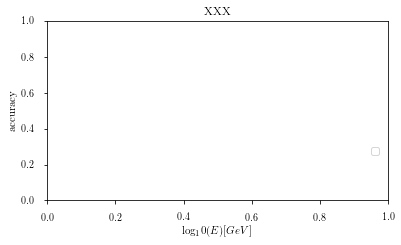

In [59]:
#THEO PLOT STYLE
fig, ax1 = newfig(0.9)

x = np.linspace(1, len(epochs_acc_loss[0]), num=len(epochs_acc_loss[0]), endpoint=True)

ax1.legend(bbox_to_anchor=(0.975 , 0.3), ncol=2, borderaxespad=0.) #loc ='best'
ax1.set_title(r"XXX")#, fontsize=18)
ax1.set_xlabel(r'log_10(E) [GeV]')#, fontsize=16)
ax1.set_ylabel(r'accuracy')#, fontsize=16)
#ax1.set_ylim(-0.2, 1.05)